# Overview

In this tutorial we will create a model for deep clustering as a pretext task for kidney segmentation.

This tutorial is part of the class **Introduction to Deep Learning for Medical Imaging** at University of California Irvine (CS190); more information can be found at: https://github.com/peterchang77/dl_tutor/tree/master/cs190.

# Google Colab

The following lines of code will configure your Google Colab environment for this tutorial.

### Enable GPU runtime

Use the following instructions to switch the default Colab instance into a GPU-enabled runtime:

```
Runtime > Change runtime type > Hardware accelerator > GPU
```

# Environment

### Jarvis library

In this notebook we will Jarvis, a custom Python package to facilitate data science and deep learning for healthcare. Among other things, this library will be used for low-level data management, stratification and visualization of high-dimensional medical data.

In [3]:
# --- Install jarvis (only in Google Colab or local runtime)
% pip install jarvis-md

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 89 kB 3.0 MB/s 
     |████████████████████████████████| 596 kB 7.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


### faiss library

To facilitate fast kmeans clustering, we will use an efficient algorithm implemented by the Facebook AI Research team as part of the `faiss` library. In brief, `faiss` is a library for efficient similarity search and clustering of dense vectors. More information can be found here: https://github.com/facebookresearch/faiss.

In [4]:
# --- Install faiss
% pip install faiss-cpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.6 MB 4.2 MB/s 


### Imports

Use the following lines to import any additional needed libraries:

In [5]:
import numpy as np, pandas as pd
from scipy import ndimage
import tensorflow as tf
from tensorflow.keras import Input, Model, models, losses, metrics, layers, optimizers
import faiss
from jarvis.train import datasets
from jarvis.utils import io
from jarvis.utils.display import imshow

# Data

The data used in this tutorial will consist of kidney tumor CT exams derived from the Kidney Tumor Segmentation Challenge (KiTS). More information about he KiTS Challenge can be found here: https://kits21.kits-challenge.org/. In this exercise, we will use this dataset to derive a model for slice-by-slice kidney segmentation. The custom `datasets.download(...)` method can be used to download a local copy of the dataset. By default the dataset will be archived at `/data/raw/ct_kits`; as needed an alternate location may be specified using `datasets.download(name=..., path=...)`. 

In [6]:
# --- Download dataset
datasets.download(name='ct/kits')

[ 2022-05-26 22:20:21 ] [====================] 100.000% : Extracting archive (0000818 / 0000818) 

{'code': '/data/raw/ct_kits', 'data': '/data/raw/ct_kits'}

### Data loader

In this tutorial, only the middle 2D slice of each volume will be used to promote fast model convergence. Since this small dataset fits easily into RAM memory, the following code block may be used to load these slices into a single Numpy array. Preparing data in this manner will also facilitate rapid iteration including efficient dataset clustering during the training process.

In [7]:
def load_data(label=1, flip=True, a_min=-128, a_max=256):

    # --- Create data client
    _, _, client = datasets.prepare(name='ct/kits', keyword='3d')

    dats, lbls = [], []

    for sid, fnames, header in client.db.cursor():

        lbl, _ = io.load(fnames['lbl-crp'])
        
        if label in lbl:
            
            dat, _ = io.load(fnames['dat-crp'])
            dats.append(dat[48:49])
            lbls.append(lbl[48:49] >= label)

            if header['cohort-left'] and flip:
                dats[-1]= dats[-1][..., ::-1, :]
                lbls[-1]= lbls[-1][..., ::-1, :]

    dats = np.stack(dats, axis=0)
    lbls = np.stack(lbls, axis=0)
    
    # --- Nomralize dats
    dats = (dats - a_min) / (a_max - a_min)
    dats = dats.clip(min=0, max=1)

    return {'dat': dats, 'lbl': lbls}

Use the following cell to load all data into the `xs` dictionary:

In [8]:
# --- Load data
xs = load_data()

[ 2022-05-26 22:20:39 ] [====================] 100.000% : Iterating | 000402    

### KITS Data

The input images in the variable `dat` are matrices of shape `1 x 96 x 96 x 1`. Note that even though the images here are 2D in shape, the full matrix is a 3D tensor `(z, y, x)` where `z = 1` in this implementation. Note that although the 3rd z-axis dimension is redundant here (for a single slice input), more complex models and architectures will commonly require a full 3D tensor. Because of this, we will directly use 3D convolutions throughout the tutorial materials for consistency.

Use the following lines of code to visualize using the `imshow(...)` method:

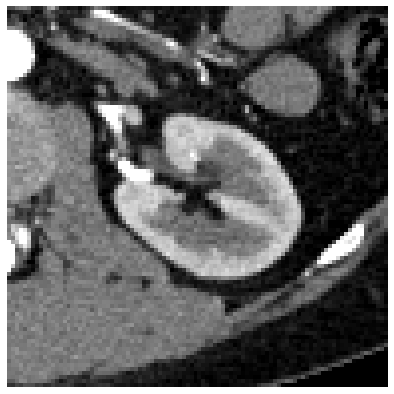

In [9]:
# --- Show the first example
imshow(xs['dat'][0])

Use the `montage(...)` function to create an N x N mosaic of all images:

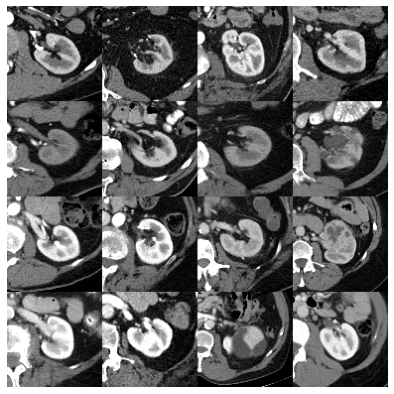

In [10]:
# --- Show "montage" of 16 images
imshow(xs['dat'][:16])

### Kidney masks

The ground-truth labels are two class masks of the same matrix shape as the model input:

In [11]:
print(xs['lbl'][0].shape)

(1, 96, 96, 1)


The three classes represent:

* class 0: background
* class 1: kidney

Use the `imshow(...)` method to visualize the ground-truth tumor mask labels:

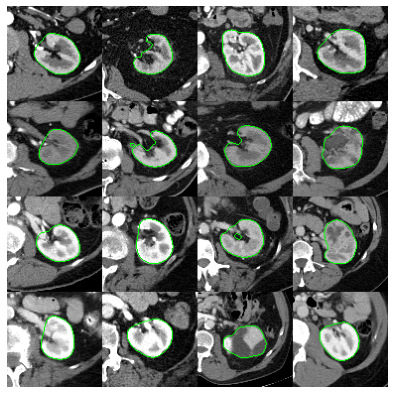

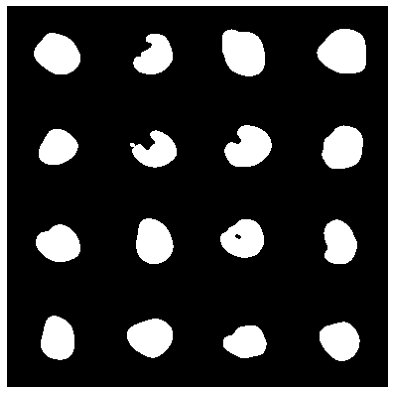

In [12]:
# --- Show tumor masks overlaid on original data
imshow(xs['dat'][:16], xs['lbl'][:16])

# --- Show tumor masks isolated
imshow(xs['lbl'][:16])

# Clusters

To create useful clusters for semantic segmentation, consider the following potential features:

* pixel (voxel) value
* pixel (voxel) coordinate location
* CNN-derived features from algorithm training

Note that CNN-based features may be more discriminative, however cannot be used until at least one round of algorithm training has been performed.

The following block can be used to create a pixel-wise (voxel-wise) feature vector based on various permuatations.

In [13]:
def create_features(x, x_weight=1, x_blur=3, coords_weight=1., backbone=None, backbone_weight=1., **kwargs):
    """
    Method to construct feature vector for clustering
    
    """
    x_ = [] 

    # --- Use features from raw data voxels
    if x_weight > 0:
        xx = x.copy()
        if x_blur > 0:
            xx[:, 0] = ndimage.gaussian_filter(xx[:, 0], sigma=(0, x_blur, x_blur, 0))
        x_.append(xx * x_weight)

    # --- Use features from coordinate location
    if coords_weight > 0:
        ij = np.meshgrid(*tuple([np.linspace(0, 1, 96) for _ in range(2)]), indexing='ij')
        ij = np.expand_dims(np.stack(ij, axis=-1), axis=0)
        ij = np.stack([ij] * x.shape[0], axis=0)
        x_.append(ij * coords_weight)

    # --- Use features from CNN-derived backbone
    if backbone is not None:
        yy = backbone.predict(x)
        x_.append(yy * backbone_weight)

    return np.concatenate(x_, axis=-1).reshape(x.size, -1)

Based on the chosen feature feature combination, perform clustering using the `faiss` library. The following method creates a total of `n_clusters` from the input data: 

In [14]:
def create_clusters(x, n_clusters=8, **kwargs):

    # --- Create features
    x_ = create_features(x=x, **kwargs)

    # --- Apply kmeans clustering
    kmeans = faiss.Kmeans(x_.shape[-1], n_clusters)
    kmeans.train(x_.astype('float32'))
    clusters = kmeans.index.search(x_.astype('float32'), 1)[1].reshape(x.shape)

    return kmeans, clusters

Use these methods as follows:

In [15]:
kmeans, clusters = create_clusters(x=xs['dat'], n_clusters=8)

To visualize clusters, use the `imshow(...)` method:

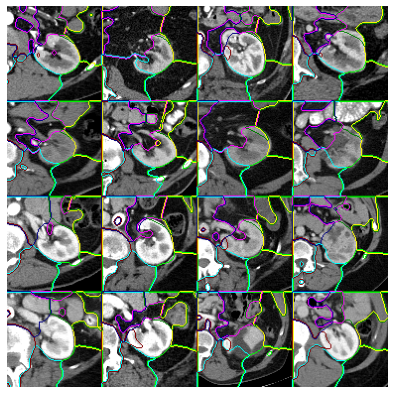

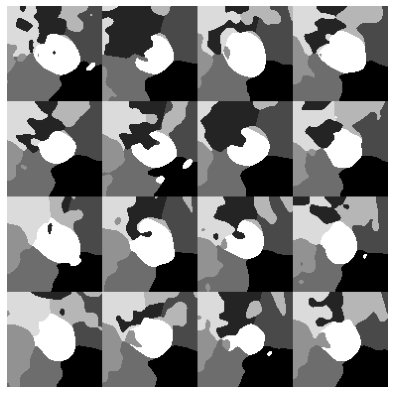

In [16]:
imshow(xs['dat'][:16], clusters[:16])
imshow(clusters[:16])

**Checkpoint**: What happens when you change the composition of the feature vector or total number of clusters used for the k-means clustering algorithm? 

# Model

For this task, we will implement a standard contracting-expanding network for semantic segmentation (e.g. U-Net). In the assignment, feel free to try various architecture permutations.

### Create backbone

Define standard lambda functions:

In [17]:
# --- Define kwargs dictionary
kwargs = {
    'kernel_size': (1, 3, 3),
    'padding': 'same'}

# --- Define lambda functions
conv = lambda x, filters, strides : layers.Conv3D(filters=filters, strides=strides, **kwargs)(x)
norm = lambda x : layers.BatchNormalization()(x)
relu = lambda x : layers.ReLU()(x)
tran = lambda x, filters, strides : layers.Conv3DTranspose(filters=filters, strides=strides, **kwargs)(x)

concat = lambda a, b : layers.Concatenate()([a, b])

# --- Define stride-1, stride-2 blocks
conv1 = lambda filters, x : relu(norm(conv(x, filters, strides=1)))
conv2 = lambda filters, x : relu(norm(conv(x, filters, strides=(1, 2, 2))))
tran2 = lambda filters, x : relu(norm(tran(x, filters, strides=(1, 2, 2))))

Now define a standard U-Net backbone using a formal method in order to facilate reuse in downstream training models:

In [18]:
def create_unet():
    
    # --- Input input
    x = Input(shape=(None, 96, 96, 1), dtype='float32')

    # --- Define contracting layers
    l1 = conv1(8, x)
    l2 = conv1(16, conv2(16, l1))
    l3 = conv1(32, conv2(32, l2))
    l4 = conv1(48, conv2(48, l3))
    l5 = conv1(64, conv2(64, l4))

    # --- Define expanding layers
    l6  = tran2(48, l5)
    l7  = tran2(32, conv1(48, concat(l4, l6)))
    l8  = tran2(16, conv1(32, concat(l3, l7)))
    l9  = tran2(8,  conv1(16, concat(l2, l8)))
    l10 = conv1(8,  l9)

    # --- Create embedding
    outputs = layers.Conv3D(filters=8, **kwargs)(l10)

    # --- Create model
    backbone = Model(inputs=x, outputs=outputs) 
    
    return backbone

# Training model

Using this `backbone` model, a total of two separate `training` models need to be created:

* training for deep clustering pretext task (pretraining)
* training for kidney segmentation task (fine-tuning)

For both `training` models, the `backbone` model architecture is wrapped in a second model with additional layer(s) that define optimization behavior including loss function derivations.

### Shared Methods

For both the pretraining and fine-tuning tasks, the following shared components may be defined:

* generic method for creating algorithn inputs
* generic method for compiling model (including losses and metrics)

### Inputs

Use the following block to define model inputs. To implement data augmentation, consider using the random rotation, translation and zoom layers as part of the TensorFlow / Keras library.

In [19]:
def create_inputs(use_augmentation=True, **kwargs):
    """
    Method to create generic model inputs (for pretraining and fine-tuning)
    
    """
    x = Input(shape=(None, 96, 96, 1))
    y = Input(shape=(None, 96, 96, 1))

    inputs = {'x': x, 'y': y}

    # --- Data augmentation
    if use_augmentation:
        
        a = layers.Concatenate()((inputs['x'][:, 0], inputs['y'][:, 0]))
        a = layers.experimental.preprocessing.RandomRotation(factor=0.2, interpolation='nearest')(a)
        a = layers.experimental.preprocessing.RandomTranslation(0.2, 0.2, interpolation='nearest')(a)
        a = layers.experimental.preprocessing.RandomZoom(0.2, interpolation='nearest')(a)
        a = tf.expand_dims(a, axis=1)

        x = a[..., 0:1]
        y = a[..., 1:2]
        
    return inputs, x, y

### Dice score

Use the following block to define a Dice score metric:

In [20]:
def calculate_dsc(y_true, y_pred, cls=1):
    """ 
    Method to calculate Dice score for given class
    
    """
    true = y_true[..., 0] == cls
    pred = tf.math.argmax(y_pred, axis=-1) == cls

    A = tf.math.count_nonzero(true & pred) * 2
    B = tf.math.count_nonzero(true) + tf.math.count_nonzero(pred)

    return tf.math.divide_no_nan(tf.cast(A, tf.float32), tf.cast(B, tf.float32))

### Compile

Use the following block to compile a generic model using a sparse softmax cross-entropy loss function and accuracy metric. Additionally, add an optional Dice score metric (for the kidney segmentation task): 

In [21]:
def compile_model(training, y, outputs, use_dsc=False, **kwargs):

    sce = losses.SparseCategoricalCrossentropy(from_logits=True)(y_true=y, y_pred=outputs)
    acc = metrics.sparse_categorical_accuracy(y_true=y, y_pred=outputs)

    training.add_loss(sce)
    training.add_metric(acc, 'acc')

    if use_dsc:
        dsc = calculate_dsc(y_true=y, y_pred=outputs)
        training.add_metric(dsc, 'dsc')

    training.compile(optimizer=optimizers.Adam(learning_rate=1e-3))

    return training

## Pretraining Model

Now we can define our pretraining model in a Python method to reuse during the formal deep clustering training loop. Note that this model is implemented as an *N-class* segmentation problem where the total number of classes is equivalent to the number of classes. Thus the model output logit scores are defined as follows:

```
outputs = layers.Conv3D(kernel_size=1, filters=(clusters.max() + 1))(outputs)
```

Note that while the `backbone` may potentially be reused if passed as a keyword argument into this function, the classification head for producing logit scores must be redefined every loop.

In [22]:
def pretrain(xs, clusters, backbone=None, epochs=50, batch_size=15, **kwargs):

    # --- Create inputs
    inputs, x, y = create_inputs(**kwargs)

    # --- Create backbone (unet)
    if backbone is None:
        backbone = create_unet()

    # --- Create training outputs
    outputs = backbone(x)
    outputs = layers.Conv3D(kernel_size=1, filters=(clusters.max() + 1))(outputs)
    
    # --- Create training model and losses
    training = Model(inputs=inputs, outputs=outputs)
    training = compile_model(training, y, outputs)

    # --- Train
    training.fit(x={'x': xs['dat'], 'y': clusters}, epochs=epochs, batch_size=batch_size)

    return backbone, training

Try a loop for training now:

In [23]:
# --- Test one epoch of training
backbone, training = pretrain(xs, clusters)

Epoch 1/50
27/27 [==============================] - 26s 822ms/step - loss: 1.8938 - acc: 0.2794
Epoch 2/50
27/27 [==============================] - 24s 873ms/step - loss: 1.4193 - acc: 0.4736
Epoch 3/50
27/27 [==============================] - 21s 762ms/step - loss: 1.1690 - acc: 0.5519
Epoch 4/50
27/27 [==============================] - 21s 788ms/step - loss: 1.0035 - acc: 0.6265
Epoch 5/50
27/27 [==============================] - 21s 775ms/step - loss: 0.9011 - acc: 0.6628
Epoch 6/50
27/27 [==============================] - 23s 838ms/step - loss: 0.7981 - acc: 0.7044
Epoch 7/50
27/27 [==============================] - 21s 788ms/step - loss: 0.7697 - acc: 0.7145
Epoch 8/50
27/27 [==============================] - 21s 775ms/step - loss: 0.7012 - acc: 0.7365
Epoch 9/50
27/27 [==============================] - 21s 777ms/step - loss: 0.6481 - acc: 0.7657
Epoch 10/50
27/27 [==============================] - 21s 773ms/step - loss: 0.6104 - acc: 0.7818
Epoch 11/50
27/27 [====================

## Fine-tuning Model

Now we can define our fine-tuning model in a Python method to reuse during the formal deep clustering training loop. Note that this model is implemented as a 2-class segmentation problem (kidney vs. no kidney). Thus the model output logit scores are defined as follows:

```
outputs = layers.Conv3D(kernel_size=1, filters=2)(outputs)
```

In [ ]:
def finetune(xs, backbone=None, n_training=10, epochs=500, batch_size=15, validation_freq=50, **kwargs): 

    # --- Create inputs
    inputs, x, y = create_inputs(**kwargs)

    # --- Create backbone (unet)
    if backbone is None:
        backbone = create_unet()

    # --- Create training outputs
    outputs = backbone(x)
    outputs = layers.Conv3D(kernel_size=1, filters=2)(outputs)
    
    # --- Create training model and losses
    training = Model(inputs=inputs, outputs=outputs)
    training = compile_model(training, y, outputs, use_dsc=True)

    # --- Train
    training.fit(
        x={'x': xs['dat'][:n_training], 'y': xs['lbl'][:n_training]}, 
        validation_data={'x': xs['dat'][n_training:], 'y': xs['lbl'][n_training:]}, 
        validation_freq=validation_freq,
        batch_size=max(n_training, batch_size),
        epochs=epochs)

    return backbone, training

Try a loop for training now:

In [ ]:
# --- Test one epoch of training
backbone, training = finetune(xs, backbone=backbone)

### Deep Clustering Training Loop

To implement a deep clustering algorithm, recall that alternating kmeans clustering and classification training steps are performed serially throughout the optimization process.

1. Create clusters using baseline kmeans
2. Supervised training using kmeans-derived pseudolabels
3. Update clusters using deep learning features
4. Supervised training using updated kmeans-derived pseudolabels

... and so on.

In [ ]:
def run_experiment(xs, n_clusters=8, epochs=3, pretrain_epochs=50, finetune_epochs=500, n_training=10):

    backbone = None
    
    for epoch in range(epochs):

        print('==================================================================')
        print('STARTING EPOCH: {}'.format(epoch + 1))
        print('==================================================================')

        # --- Create clusters
        kwargs = {
            'backbone': backbone, 
            'x_weight': 1. if epoch == 0 else 0, 
            'coords_weight': 1. if epoch == 0 else 0}

        kmeans, clusters = create_clusters(xs=xs, n_clusters=n_clusters, **kwargs)

        # --- Perform pretraining
        backbone, training = pretrain(xs=xs, clusters=clusters, backbone=backbone, epochs=pretrain_epochs)

    # --- Perform fine-tuning
    backbone, training = finetune(xs=xs, backbone=backbone, n_training=n_training, epochs=finetune_epochs)
    
    return backbone, training

Use this block to initiate a deep clustering training loop:

In [ ]:
backbone, training = run_experiment(xs)

# Evaluation

Use the converged `training` model to evaluate performance. Note that `backbone` only contains the pretrained backbone but does not contain the final fine-tuned classification head. Because all the data is already loaded in RAM memory as a single Numpy array, the follow simple loop is satisfactory for this task:

In [ ]:
# --- Run prediction on data
n_training = 10
logits = training.predict({'x': xs['dat'], 'y': xs['lbl']})

# --- Evaluate performance of validation cohort (>n_training)
dice = []
for y_true, y_pred in zip(xs['lbl'][n_training:], logits[n_training:]):
    
    # --- Calculate Dice using metric function defined above
    dsc = calculate_dsc(y_true=y_true, y_pred=y_pred).numpy()
    dice.append(dsc)

### Saving results

In [ ]:
# --- Define columns
df = pd.DataFrame(np.arange(len(dice)))
df['dice'] = dice

## Saving and Loading a Model

After a model has been successfully trained, it can be saved and/or loaded by simply using the `training.save()` and `training.load_model()` methods. 

In [ ]:
# --- Serialize a model
training.save('./model.hdf5')

In [ ]:
# --- Load a serialized model
del training
training = models.load_model('./model.hdf5', compile=False)